Author : Debayan Saha, Myers lab. dsaha@mpi-cbg.de

In [32]:
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import glob
import scipy.ndimage.filters as filters
import scipy.ndimage as ndimage
from scipy.spatial.distance import cdist
from scipy.optimize import curve_fit
from matplotlib import cm
import os
from scipy.ndimage import generate_binary_structure
from scipy.ndimage.morphology import binary_dilation
import spimagine
%gui qt5
#%matplotlib inline

# Defining functions

In [35]:
# param : img:   3D numpy array, image
#         neighborhood_size : tuple of ints, kernel size for maxima and minma filter (z,y,x)
#         threshold : int, determines the threshold differnece between maximum peak intensity and background to count as a bead

def detectBeads(img,neighborhood_size = (5,5,5),threshold = 1500,parameterSettingMode = False):

    # Bead segmentation, the mask of the bead is in maxima
    #print("Bead Mask formation")
    data = img
    data_max = filters.maximum_filter(data, neighborhood_size)
    maxima = (data == data_max)  
    data_min = filters.minimum_filter(data, neighborhood_size)
    diff = ((data_max - data_min) > threshold)
    maxima[diff == 0] = 0
    struct = generate_binary_structure(3, 12)
    maxima = binary_dilation(maxima,struct)
    maxima = binary_dilation(maxima)
    #maxima = binary_dilation(maxima)   
    
    # Isolating beads from the mask
    #print("Bead Mask labeling")
    labeled, num_objects = ndimage.label(maxima)
    print("Num Of Objects %d"%num_objects)
    slices = ndimage.find_objects(labeled)
    x, y, z = [], [], []
    for dz,dy,dx in slices:
        z_center = (dz.start + dz.stop - 1)/2
        z.append(z_center)
        x_center = (dx.start + dx.stop - 1)/2
        x.append(x_center)
        y_center = (dy.start + dy.stop - 1)/2    
        y.append(y_center)
    
    if parameterSettingMode:
        plt.subplot(1,2,1)
        plt.imshow(np.max(data_max,axis = 0))
        plt.colorbar()
        plt.title("Maxima Filter")
        plt.subplot(1,2,2)
        plt.imshow(np.max(data_min,axis = 0))
        plt.colorbar()
        plt.title("Minima Filter")
        plt.show()
        #spimagine.volshow(maxima)
    return (z,y,x,num_objects)

In [9]:
# param : img:   3D numpy array, image
#         pos:   2D numpy array, positions of all beads in n*[z,y,x] format
#         title: String, title for the plot 

def visualizeBeadDetectionByMaxProjection(img,pos, title = "Image"):
    z,y,x = pos[:,0],pos[:,1],pos[:,2]
    plt.figure(figsize=(10,10))
    plt.imshow((np.max(img,axis = 0)))
    plt.axis('OFF')
    plt.title(title)
    for i,_ in enumerate(x):
        plt.plot(x[i],y[i],'r.',alpha = 1)
    plt.show()

In [10]:
# param: fileName: String, entire path with the filename 
#        rawImage: Boolean, if tiff file to be loaded or raw microscope image
#        dimZ,dimY,dimX: int, the dimensions, required only for raw image

def loadImage(fileName, rawImage = True, dimZ = 100, dimY = 512, dimX = 512):
    if rawImage:
        return (np.fromfile(fileName,dtype=np.dtype('<u2')).reshape((dimZ,dimY,dimX)))
    else:
        return tifffile.imread(fileName)

In [11]:
# param: img:   3D numpy array, image
#        limit: a tuple of 3 ints, extent to extract in the 3 dimension 
# .      n:     int, number of beads
#        pos:   2D numpy array, positions of all beads in n*[z,y,x] format

def extract1DSignalForAllBeadsInAll3Dims(img,limit,n,pos):
    z,y,x = pos[:,0],pos[:,1],pos[:,2]
    zrange,yrange,xrange = limit[0],limit[1],limit[2]
    switcher = {
        'z': [img[np.maximum(int(z[i])-(zrange//2),0):np.minimum(int(z[i])+(zrange//2),img.shape[0]),int(y[i]),int(x[i])].tolist() for i in range(n)],
        'y': [img[int(z[i]),np.maximum(int(y[i])-(yrange//2),0):np.minimum(int(y[i])+(yrange//2),img.shape[1]),int(x[i])].tolist() for i in range(n)],
        'x': [img[int(z[i]),int(y[i]),np.maximum(int(x[i])-(xrange//2),0):np.minimum(int(x[i])+(xrange//2),img.shape[2])].tolist() for i in range(n)],
    } 
    ZSignal = switcher.get('z', "Invalid Dimension")
    YSignal = switcher.get('y', "Invalid Dimension")
    XSignal = switcher.get('x', "Invalid Dimension")
    return (ZSignal,YSignal,XSignal)

In [12]:
# param: x : int, independent variable
#       amp: int/float, amplitude of the gaussian
#       cen: int/float, center of the gaussian
#       wid: int/float, width of the gaussian
#       ydisp: int.float, background

def gaussian(x, amp, cen, wid, ydisp):
     return (amp * np.exp(-(x-cen)**2 / wid) + ydisp)
    

# param: img:   3D numpy array, image
# .      n:     int, number of beads
#        pos:   2D numpy array, positions of all beads in n*[z,y,x] format 
#        signal: list of numpy array, each member of the list is a bead. numpy ar
#        insBead: 1D boolean array, if the detected bead is indeed a bead

def fitForAllBeads(img, n, pos, signal,isBead):
    numParams = 4
    fitParam = np.zeros((n,numParams))
    err = np.zeros((n,numParams))
    
    z,y,x = pos[:,0],pos[:,1],pos[:,2]

    for beadNum in range(n):
        #print(beadNum)
        initialVals = [img[int(z[beadNum]),int(y[beadNum]),int(x[beadNum])], len(signal[beadNum])//2, len(signal[beadNum])//2, np.min(signal[beadNum])]  #[amp, cen, wid, ydisplacement]
        try:
            # curve_fit(model,x,y,initialValues)
            bestVals, covar = curve_fit(gaussian, range(len(signal[beadNum])), signal[beadNum], p0=initialVals)
            fitParam[beadNum] = bestVals
        except:
            isBead[beadNum] = 0
            continue
        err[beadNum] = np.sqrt(np.diag(covar))
    return (fitParam.tolist(),err.tolist(),isBead)

In [13]:
# param : isBead: 1D boolean array, if the detected bead is indeed a bead
#         param: 2D numpy array, (n*m) where n is number of beads and m is number of paramenters for fitting
#         err: 2D numpy array, (n*m) where n is number of beads and m is error number in each parameter fitting
#         widthThreshold: int, threshold for maximum width of the gaussian that is fitted

def checkTheFitOfBead(isBead, param, err, limit):
    for beadNum in range(isBead.shape[0]):
        if np.any(np.isinf(err[beadNum])): # Very high variance in any parameter of fitting cannot be a bead
            isBead[beadNum] = 0
            continue
        if param[beadNum][0] <= 0: # Inverted Gaussian cannot be a bead
            isBead[beadNum] = 0
            continue
        if err[beadNum][2] > limit: # Large variance in the width of the bead, typically greater than the window size 
            isBead[beadNum] = 0
            continue      
    return isBead

In [14]:
def visualizeProfileOfBeads(img, isBead, zLimit, yLimit, xLimit, pos, ZSignal, YSignal, XSignal, ZParam, YParam, XParam, deleted = 0):
    z,y,x = pos[:,0],pos[:,1],pos[:,2]
    for beadNum in range(len(isBead)):
        if isBead[beadNum]== deleted:
            plt.figure(figsize = (10,3))
            plt.subplot(1,5,1)
            plt.plot(ZSignal[beadNum])
            plt.yticks([])
            plotx = np.linspace(0, len(ZSignal[beadNum]), 101)
            ploty = gaussian(plotx, ZParam[beadNum][0], ZParam[beadNum][1], ZParam[beadNum][2], ZParam[beadNum][3])
            plt.plot(plotx,ploty)
            plt.title("Z Profile")
            plt.subplot(1,5,2)
            plt.plot(YSignal[beadNum])
            plt.yticks([])
            plotx = np.linspace(0, len(YSignal[beadNum]), 101)
            ploty = gaussian(plotx, YParam[beadNum][0], YParam[beadNum][1], YParam[beadNum][2], YParam[beadNum][3])
            plt.plot(plotx,ploty)
            plt.title("Y Profile")
            plt.subplot(1,5,3)
            plt.plot(XSignal[beadNum])
            plt.yticks([])
            plotx = np.linspace(0, len(XSignal[beadNum]), 101)
            ploty = gaussian(plotx, XParam[beadNum][0], XParam[beadNum][1], XParam[beadNum][2], XParam[beadNum][3])
            plt.plot(plotx,ploty)
            plt.title("X Profile")
            plt.subplot(1,5,4)
            plt.imshow(img[np.maximum(int(z[beadNum])-(zLimit//2),0):np.minimum(int(z[beadNum])+(zLimit//2),img.shape[1]),
                    int(y[beadNum]),   
                    np.maximum(int(x[beadNum])-(xLimit//2),0):np.minimum(int(x[beadNum])+(xLimit//2),img.shape[2])])
            plt.yticks([])
            plt.axvline(x[beadNum]-np.maximum(int(x[beadNum])-(xLimit//2),0), color='r', linestyle='--',linewidth = 1)
            plt.title("ZX Plane")
            plt.subplot(1,5,5)
            plt.imshow(img[int(z[beadNum]),
                   np.maximum(int(y[beadNum])-(yLimit//2),0):np.minimum(int(y[beadNum])+(yLimit//2),img.shape[1]),
                    np.maximum(int(x[beadNum])-(xLimit//2),0):np.minimum(int(x[beadNum])+(xLimit//2),img.shape[2])])
            plt.yticks([])
            plt.axhline(y[beadNum]-np.maximum(int(y[beadNum])-(yLimit//2),0), color='r', linestyle='--',linewidth = 1)
            plt.axvline(x[beadNum]-np.maximum(int(x[beadNum])-(xLimit//2),0), color='r', linestyle='--',linewidth = 1)
            plt.title("XY Plane")
            plt.show()
        

In [15]:
# param : isBead: 1D boolean array, if the detected bead is indeed a bead
#         param: 2D numpy array, (n*m) where n is number of beads and m is number of paramenters for fitting
#         err: 2D numpy array, (n*m) where n is number of beads and m is error number in each parameter fitting
#         n: int, number of beads
#         pos: 2D numpy array, (n*m) n = number of beads, m= 3 for x,y,z

def deleteBeads(isBead, param, err, n, pos):
    param1 = []
    err1 = []
    pos1 = []
    for beadNum in range(n):
        #print(beadNum)
        if isBead[beadNum]:
            param1.append(param[beadNum])
            err1.append(err[beadNum])
            pos1.append(pos[beadNum])
    return (param1,err1,pos1)



In [16]:
def visualizeSizesOfBeads(img,radius,x,y, title = "Image"):
    mul = 70 
    plt.figure(figsize=(16,6))
    plt.suptitle(title)
    plt.subplot(1,2,1)
    plt.imshow(np.log(np.max(img,axis = 0)))
    plt.axis('OFF')
    cm = plt.cm.get_cmap('jet')
    sc=plt.scatter(x,y,c=radius, s=radius*mul,cmap = cm)
    plt.colorbar(sc)
    plt.subplot(1,2,2)
    plt.ylim(0,img.shape[1])
    plt.xlim(0,img.shape[2])
    sc=plt.scatter(x,y,c=radius, s=radius*mul,cmap = cm)
    cbar = plt.colorbar()
    cbar.set_label('Normalized radius', rotation=270, size = 15)
    plt.xticks([])
    plt.yticks([])
    plt.gca().invert_yaxis()
    plt.show

In [17]:
def visualizeWellFittedBeads(isBead, ZParam, YParam, Xparam, ZSignal, YSignal, XSignal, zLimit, yLimit, xLimit, pos):
    z,y,x = pos[:,0],pos[:,1],pos[:,2]
    for beadNum in range(len(isBead)):
        if isBead[beadNum]:
            plt.figure(figsize = (6.5,2))
            plt.subplot(1,3,1)
            plt.plot(XSignal[beadNum])
            plt.plot()
            plt.yticks([])
            plotx = np.linspace(0, len(XSignal[beadNum]), 101)
            ploty = gaussian(plotx, XParam[beadNum,0], XParam[beadNum,1], XParam[beadNum,2], XParam[beadNum,3])
            plt.plot(plotx,ploty)
            plt.title("Horizontal Line Profile")
            plt.subplot(1,3,2)
            plt.imshow(img[int(z[beadNum]),
                   np.maximum(int(y[beadNum])-(yLimit//2),0):np.minimum(int(y[beadNum])+(yLimit//2),img.shape[1]),
                    np.maximum(int(x[beadNum])-(xLimit//2),0):np.minimum(int(x[beadNum])+(xLimit//2),img.shape[2])])
            plt.yticks([])
            plt.axhline(y[beadNum]-np.maximum(int(y[beadNum])-(yLimit//2),0), color='r', linestyle='--',linewidth = 1)
            plt.axvline(x[beadNum]-np.maximum(int(x[beadNum])-(xLimit//2),0), color='r', linestyle='--',linewidth = 1)
            plt.title("XY plane")
            plt.subplot(1,3,3)
            plt.plot(YSignal[beadNum])
            plt.plot()
            plt.yticks([])
            _plotx = np.linspace(0, len(YSignal[beadNum]), 101)
            _ploty = gaussian(_plotx, YParam[beadNum,0], YParam[beadNum,1], YParam[beadNum,2], YParam[beadNum,3])
            plt.plot(_plotx,_ploty)
            plt.title("Vertical Line Profile")
        
            #print(XErr[i])
            plt.show()

In [18]:
def visualizeWellFittedBeadsZProfile(isBead, ZSignal, ZParam, zLimit, yLimit, xLimit):
    for beadNum in range(len(isBead)):
        if isBead[beadNum]:
            plt.figure(figsize = (4.5,2))
            plt.subplot(1,2,1)
            plt.plot(ZSignal[beadNum])
            plt.plot()
            plt.yticks([])
            plotx = np.linspace(0, len(ZSignal[beadNum]), 101)
            ploty = gaussian(plotx, ZParam[beadNum,0], ZParam[beadNum,1], ZParam[beadNum,2], ZParam[beadNum,3])
            plt.plot(plotx,ploty)
            plt.title("Z Profile")
            plt.subplot(1,2,2)
            plt.imshow(img[np.maximum(int(z[beadNum])-(zLimit//2),0):np.minimum(int(z[beadNum])+(zLimit//2),img.shape[0]),
                    int(y[beadNum]),   
                    np.maximum(int(x[beadNum])-(xLimit//2),0):np.minimum(int(x[beadNum])+(xLimit//2),img.shape[2])])
            plt.yticks([])
            plt.axvline(x[beadNum]-np.maximum(int(x[beadNum])-(xLimit//2),0), color='r', linestyle='--',linewidth = 1)
            plt.title("ZX Plane")
            plt.show()

In [19]:
def visualizeDeletedBeadsZProfile(isBead, ZSignal, ZParam, zLimit, yLimit, xLimit):
    for beadNum in range(len(isBead)):
        if isBead[beadNum]==0:
            plt.figure(figsize = (4.5,2))
            plt.subplot(1,2,1)
            plt.plot(ZSignal[beadNum])
            plt.plot()
            plt.yticks([])
            plotx = np.linspace(0, len(ZSignal[beadNum]), 101)
            ploty = gaussian(plotx, ZParam[beadNum,0], ZParam[beadNum,1], ZParam[beadNum,2], ZParam[beadNum,3])
            plt.plot(plotx,ploty)
            plt.title("Z Profile")
            plt.subplot(1,2,2)
            plt.imshow(img[np.maximum(int(z[beadNum])-(zLimit//2),0):np.minimum(int(z[beadNum])+(zLimit//2),img.shape[0]),
                    int(y[beadNum]),   
                    np.maximum(int(x[beadNum])-(xLimit//2),0):np.minimum(int(x[beadNum])+(xLimit//2),img.shape[2])])
            plt.yticks([])
            plt.axvline(x[beadNum]-np.maximum(int(x[beadNum])-(xLimit//2),0), color='r', linestyle='--',linewidth = 1)
            plt.title("ZX Plane")
            plt.show()

In [20]:
def visaulizeBeads(img,z,y,x,zLimit,yLimit,xLimit):
    plt.subplot(1,3,1)
    plt.title("XY Profile")
    plt.imshow(img[int(z),
                   np.maximum(int(y)-(yLimit//2),0):np.minimum(int(y)+(yLimit//2),img.shape[1]),
                   np.maximum(int(x)-(xLimit//2),0):np.minimum(int(x)+(xLimit//2),img.shape[2])])
    plt.subplot(1,3,2)
    plt.title("ZX Profile")
    plt.imshow(img[np.maximum(int(z)-(zLimit//2),0):np.minimum(int(z)+(zLimit//2),img.shape[0]),
                    int(y),   
                    np.maximum(int(x)-(xLimit//2),0):np.minimum(int(x)+(xLimit//2),img.shape[2])])
    plt.subplot(1,3,3)
    plt.title("ZY Profile")
    plt.imshow(img[np.maximum(int(z)-(zLimit//2),0):np.minimum(int(z)+(zLimit//2),img.shape[0]),
                    np.maximum(int(y)-(yLimit//2),0):np.minimum(int(y)+(yLimit//2),img.shape[1]),
                   int(x)])
    plt.show()

# Processing Images

### Folder path and mode of operation

In [49]:
# Input cell

folder = os.path.join("D:","Data","2018-09-19-14-07-24-96-RandomZernikeAstigmation","stacks","TrainingBead")
ext = ".tif" 
parameterSettingmode = True; #the mode of operation. When you are setting the parameters make it True. 
                             #When you want to process all images in a folder make it false

In [50]:
# Output cell

files = glob.glob(os.path.join(folder, "*" + ext))  #Check that you hvae got all the files
print("Got these files from the folder")
print ('\n'.join(files)) #Check that you hvae got all the files

if parameterSettingmode:
    numberOfImages = 1
    print("\nWe are in parameter setting mode:  working on the first image file")
else:
    numberOfImages = len(files)
    print("\nWe are in folder processing mode:  working on all the images in the folder")

Got these files from the folder
D:Data\2018-09-19-14-07-24-96-RandomZernikeAstigmation\stacks\TrainingBead\000001.tif
D:Data\2018-09-19-14-07-24-96-RandomZernikeAstigmation\stacks\TrainingBead\000002.tif
D:Data\2018-09-19-14-07-24-96-RandomZernikeAstigmation\stacks\TrainingBead\000003.tif
D:Data\2018-09-19-14-07-24-96-RandomZernikeAstigmation\stacks\TrainingBead\000004.tif
D:Data\2018-09-19-14-07-24-96-RandomZernikeAstigmation\stacks\TrainingBead\000005.tif
D:Data\2018-09-19-14-07-24-96-RandomZernikeAstigmation\stacks\TrainingBead\000006.tif
D:Data\2018-09-19-14-07-24-96-RandomZernikeAstigmation\stacks\TrainingBead\000007.tif
D:Data\2018-09-19-14-07-24-96-RandomZernikeAstigmation\stacks\TrainingBead\000008.tif
D:Data\2018-09-19-14-07-24-96-RandomZernikeAstigmation\stacks\TrainingBead\000009.tif
D:Data\2018-09-19-14-07-24-96-RandomZernikeAstigmation\stacks\TrainingBead\000010.tif
D:Data\2018-09-19-14-07-24-96-RandomZernikeAstigmation\stacks\TrainingBead\000011.tif
D:Data\2018-09-19-14-0

### Raw or Tiff images

In [51]:
# Input cell

isFileTypeRaw = False; 

#Change these numbers only if isFileTypeRaw: True
zdim = 401
ydim = 1024
xdim = 1024    

In [52]:
# Output cell

img = [[]]*numberOfImages;
for i in range(numberOfImages):
    img[i] = loadImage(files[i],isFileTypeRaw,401,1024,1024)
img = np.array(img)
print("(Number of images, Z, Y, X) : %s"%(img.shape,))

(Number of images, Z, Y, X) : (1, 151, 273, 341)


### Gaussian smoothening

In [53]:
# Input Cell

gaussianFilterSize = 2

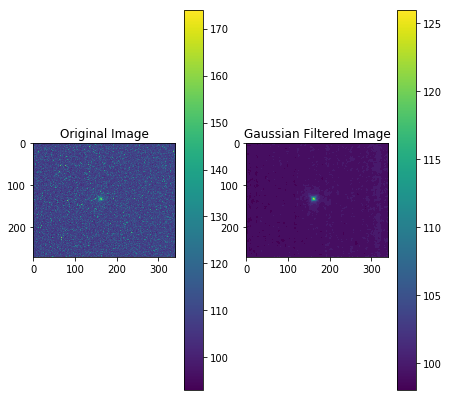

In [54]:
# Output Cell

gImg = [filters.gaussian_filter(i,gaussianFilterSize) for i in img]

if(parameterSettingmode):
    plt.figure(figsize=(7,7))
    plt.subplot(1,2,1)
    plt.imshow(np.max(img[0],0))
    plt.title("Original Image")
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.imshow(np.max(gImg[0],0))
    plt.title("Gaussian Filtered Image")
    plt.colorbar()

### Object detection parameters

In [55]:
# Input Cell

#For beads in agarose
threshold=10 # Thresholding difference between background and foreground that determines to be a bead
neighborhood_size=(5,10,10) # Kernel size for maxima and minima filter

# For Droso uNS image
#threshold=2000
#neighborhood_size=(50,30,30)

Detecting all objects that can qualify as beads
Num Of Objects 1


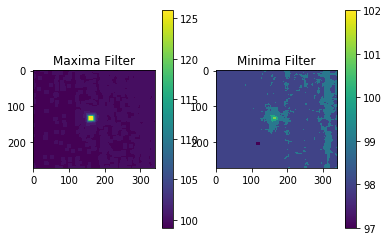

Detected 1 objects that can qualify as beads


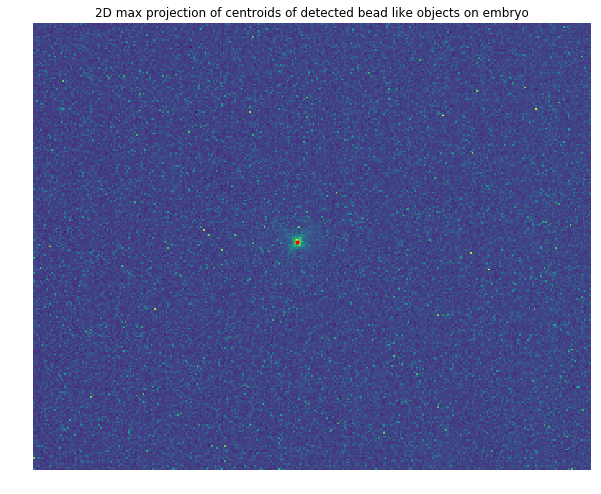

In [56]:
# Output Cell

#gImg =img
isBead = [[]]*numberOfImages;
detectedBeadPos = [[]]*numberOfImages;
z,y,x,n = [[]]*numberOfImages,[[]]*numberOfImages,[[]]*numberOfImages,[[]]*numberOfImages
print("Detecting all objects that can qualify as beads")
for imageNumber in range(numberOfImages):
    (z[imageNumber],y[imageNumber],x[imageNumber],n[imageNumber]) = detectBeads(gImg[imageNumber],neighborhood_size=neighborhood_size,threshold=threshold,parameterSettingMode=parameterSettingmode)
    isBead[imageNumber] = np.ones((n[imageNumber])) # will contain information about the detected beads that actually qualify as beads
    detectedBeadPos[imageNumber] = np.array([(z[imageNumber][i],y[imageNumber][i],x[imageNumber][i]) 
                                             for i in range(n[imageNumber]) if isBead[imageNumber][i]])

if parameterSettingmode:
    print("Detected %d objects that can qualify as beads"%n[imageNumber])
    visualizeBeadDetectionByMaxProjection(img[0],detectedBeadPos[0],"2D max projection of centroids of detected bead like objects on embryo")

### Range of signal extraction

In [57]:
# Input cell

zLimit,yLimit,xLimit = 100,64,64 #The range for extracting 1D signal along respective axis

Extracting 1D signals along x, y and z axis


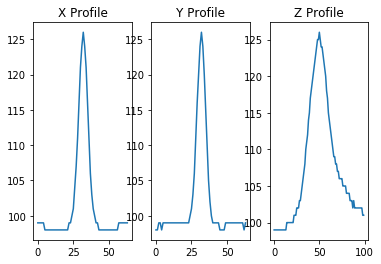

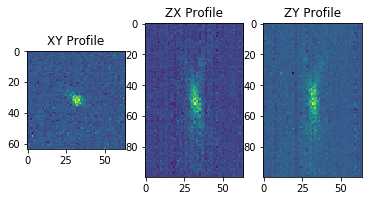

In [58]:
# Output Cell

print("Extracting 1D signals along x, y and z axis")

ZSignal,YSignal,XSignal = [[[]]]*numberOfImages,[[[]]]*numberOfImages,[[[]]]*numberOfImages

for imageNumber in range(numberOfImages):
    ZSignal[imageNumber],YSignal[imageNumber],XSignal[imageNumber] = extract1DSignalForAllBeadsInAll3Dims(gImg[imageNumber],(zLimit,yLimit,xLimit),n[imageNumber],detectedBeadPos[imageNumber])

    
if parameterSettingmode:
    beadNum = 0
    plt.subplot(1,3,1)
    plt.plot(XSignal[imageNumber][beadNum])
    plt.title("X Profile")
    plt.subplot(1,3,2)
    plt.plot(YSignal[imageNumber][beadNum])
    plt.title("Y Profile")
    plt.subplot(1,3,3)
    plt.plot(ZSignal[imageNumber][beadNum])
    plt.title("Z Profile")
    plt.show()
    visaulizeBeads(img[imageNumber], detectedBeadPos[imageNumber][beadNum,0],detectedBeadPos[imageNumber][beadNum,1],
                   detectedBeadPos[imageNumber][beadNum,2],zLimit=zLimit, yLimit=yLimit, xLimit=xLimit)

### Tolerance in fitting for object to be abead

In [59]:
# Input Cell

errorInZWidthFitting = zLimit
errorInYWidthFitting = yLimit/4
errorInXWidthFitting = xLimit/4

In [60]:
# Output cell

#Gaussian fitting of signal from propbable beads in all 3 dimensions
ZParam, YParam, XParam = [[[]]]*numberOfImages,[[[]]]*numberOfImages,[[[]]]*numberOfImages
ZErr, YErr, XErr = [[[]]]*numberOfImages,[[[]]]*numberOfImages,[[[]]]*numberOfImages

for imageNumber in range(numberOfImages):
    ZParam[imageNumber],ZErr[imageNumber],isBead[imageNumber] = fitForAllBeads(img[imageNumber],n[imageNumber],detectedBeadPos[imageNumber],ZSignal[imageNumber],isBead[imageNumber])
    YParam[imageNumber],YErr[imageNumber],isBead[imageNumber] = fitForAllBeads(img[imageNumber],n[imageNumber],detectedBeadPos[imageNumber],YSignal[imageNumber],isBead[imageNumber])
    XParam[imageNumber],XErr[imageNumber],isBead[imageNumber] = fitForAllBeads(img[imageNumber],n[imageNumber],detectedBeadPos[imageNumber],XSignal[imageNumber],isBead[imageNumber])

    #"Checking which of the detected objects qaulify as beads
    isBead[imageNumber] = checkTheFitOfBead(isBead[imageNumber], ZParam[imageNumber], ZErr[imageNumber], errorInZWidthFitting)
    isBead[imageNumber] = checkTheFitOfBead(isBead[imageNumber], YParam[imageNumber], YErr[imageNumber], errorInYWidthFitting)
    isBead[imageNumber] = checkTheFitOfBead(isBead[imageNumber], XParam[imageNumber], XErr[imageNumber], errorInXWidthFitting)

    # Visulaize Deleted Beads
    if parameterSettingmode:
        print("These beads are being deleted")
        visualizeProfileOfBeads(img[imageNumber],isBead[imageNumber],
                          zLimit,yLimit,xLimit,detectedBeadPos[imageNumber],ZSignal[imageNumber],YSignal[imageNumber],
                          XSignal[imageNumber],ZParam[imageNumber],YParam[imageNumber],XParam[imageNumber],0)

These beads are being deleted


These beads are well fitted


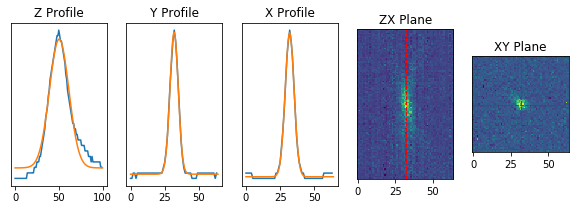

In [61]:
# Output cell

#Visulaize Well fitted Beads
imageNum = 0
if parameterSettingmode:
    print("These beads are well fitted")
    visualizeProfileOfBeads(img[imageNumber],isBead[imageNumber],
                          zLimit,yLimit,xLimit,detectedBeadPos[imageNumber],ZSignal[imageNumber],YSignal[imageNumber],
                          XSignal[imageNumber],ZParam[imageNumber],YParam[imageNumber],XParam[imageNumber],1)

Deleting information about objects not qualified as beads


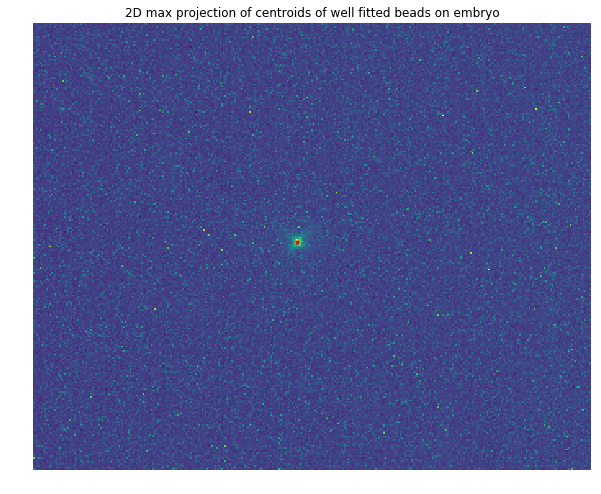

In [62]:
# Output Cell

beadPos = [[]]*numberOfImages;
print("Deleting information about objects not qualified as beads")
for imageNumber in range(numberOfImages):
    ZParam[imageNumber],ZErr[imageNumber],z[imageNumber] = deleteBeads(isBead[imageNumber], ZParam[imageNumber], ZErr[imageNumber], n[imageNumber], z[imageNumber])
    YParam[imageNumber],YErr[imageNumber],y[imageNumber] = deleteBeads(isBead[imageNumber], YParam[imageNumber], YErr[imageNumber], n[imageNumber], y[imageNumber])
    XParam[imageNumber],XErr[imageNumber],x[imageNumber] = deleteBeads(isBead[imageNumber], XParam[imageNumber], XErr[imageNumber], n[imageNumber], x[imageNumber])



    assert(len(z[imageNumber]) == len (y[imageNumber]) == len(x[imageNumber]) == len(ZParam[imageNumber]) == len(YParam[imageNumber]) 
           == len(XParam[imageNumber]) == len(ZErr[imageNumber]) == len(YErr[imageNumber]) == len(XErr[imageNumber]))

    n[imageNumber] = len(z[imageNumber])
    isBead[imageNumber] = np.ones(n[imageNumber])
    beadPos[imageNumber] = np.array([(z[imageNumber][i],y[imageNumber][i],x[imageNumber][i]) 
                                             for i in range(n[imageNumber]) if isBead[imageNumber][i]])

imageNum = 0
if parameterSettingmode:
    visualizeBeadDetectionByMaxProjection(img[imageNum],beadPos[imageNum], "2D max projection of centroids of well fitted beads on embryo")

C:\Users\myerslab\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
C:\Users\myerslab\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\myerslab\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


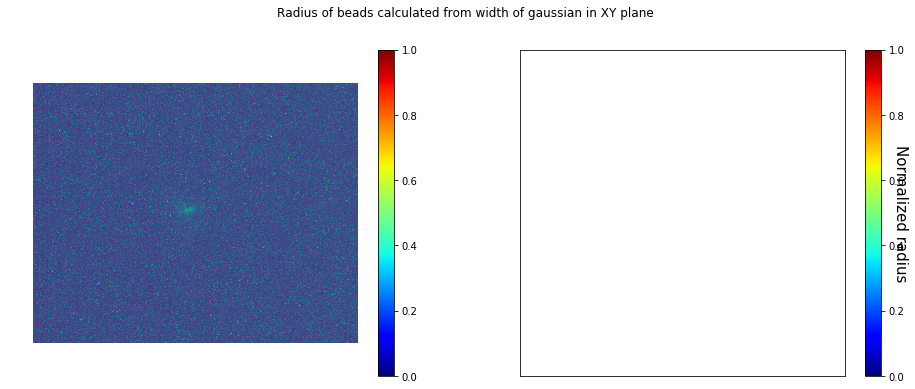

In [43]:
# Visulaize Size of beads
# FIX PROBLEM = Single Bead
imageNum = 0
if parameterSettingmode:
    zWidth = (np.array(ZParam[imageNum])[:,2] - np.min(np.array(ZParam[imageNum])[:,2]))/(np.max(np.array(ZParam[imageNum])[:,2]) - np.min(np.array(ZParam[imageNum])[:,2]))
    yWidth = (np.array(YParam[imageNum])[:,2] - np.min(np.array(YParam[imageNum])[:,2]))/(np.max(np.array(YParam[imageNum])[:,2]) - np.min(np.array(YParam[imageNum])[:,2]))
    xWidth = (np.array(XParam[imageNum])[:,2] - np.min(np.array(XParam[imageNum])[:,2]))/(np.max(np.array(XParam[imageNum])[:,2]) - np.min(np.array(XParam[imageNum])[:,2]))
    xyRadius = np.sqrt(np.square(xWidth) + np.square(yWidth))
    xyRadius = (xyRadius - np.min(xyRadius))/(np.max(xyRadius) - np.min(xyRadius))
    #visualizeSizesOfBeads(img,zWidth,x,y,"Width of gaussian along Z axis")
    #visualizeSizesOfBeads(img,yWidth,x,y,"Width of gaussian along Y axis")
    #visualizeSizesOfBeads(img,xWidth,x,y,"Width of gaussian along X axis")
    visualizeSizesOfBeads(img[imageNum],xyRadius,x[imageNum],y[imageNum], "Radius of beads calculated from width of gaussian in XY plane")

In [ ]:
# Writing csv files to directory

if not parameterSettingmode:
    if not os.path.exists(folder + "\\Analysis"):
        os.makedirs(folder + "\\Analysis")

    
    for imageNum in range(numberOfImages):
        f = open(folder + "\\Analysis\\ZParam%d.csv"%imageNum,'w')
        np.savetxt(f, ZParam[imageNum], delimiter=",")
        f.close()
        f = open(folder + "\\Analysis\\YParam%d.csv"%imageNum,'w')
        np.savetxt(f, YParam[imageNum], delimiter=",")
        f.close()
        f = open(folder + "\\Analysis\\XParam%d.csv"%imageNum,'w')
        np.savetxt(f, XParam[imageNum], delimiter=",")
        f.close()